<a href="https://colab.research.google.com/github/mvlier/topapprox/blob/main/Interactive_Tutorial_topapprox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install the latest topapprox package

This may take around a minute.

In [ ]:
# First, Install the topapprox dependencies
!pip install -U -q numba numpy networkx
# !pip install git+https://github.com/mvlier/topapprox@main

In [ ]:
# Additional packages for some examples
!pip install -U -q cripser persim seaborn matplotlib scikit-image tqdm

# Tutorial

Import the package.

In [1]:
import topapprox as ta

Import other necessary packages for this tutorial.

In [2]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['text.usetex'] = False


##  Toy example with a 2D image

We can construct an image by setting the values of each pixel as follows.

In [3]:
img = np.array([[0, 5, 3],\
                [5,5.1,4],\
                [2, 5, 1]])

And we can visualize the image with seaborn as follows.

<Axes: >

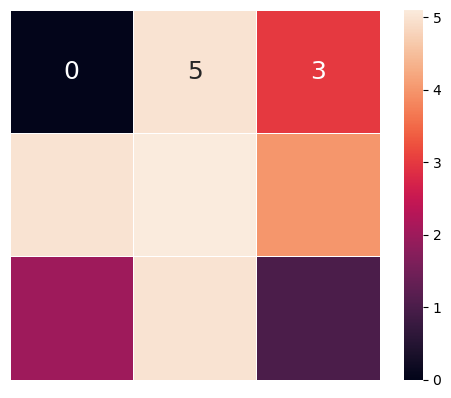

In [4]:
sns.heatmap(img, annot=True, linewidths=0.5, square=True, yticklabels=False, xticklabels=False, annot_kws={"fontsize":18})

### PH0: 0-dimensional

<Axes: >

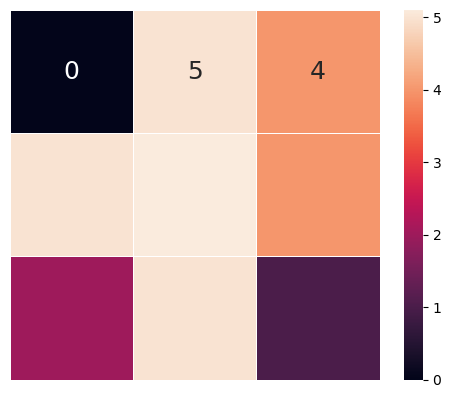

In [6]:
uf = ta.TopologicalFilterImage(img, dual=False)
try: # for some unknown reasons, the initial compilation of numba functions throws an assertion error
    img_filtered = uf.highpass_filter(2)
except:
    img_filtered = uf.highpass_filter(2)
sns.heatmap(img_filtered, annot=True, linewidths=0.5, square=True, yticklabels=False, xticklabels=False, annot_kws={"fontsize":18})

<Axes: >

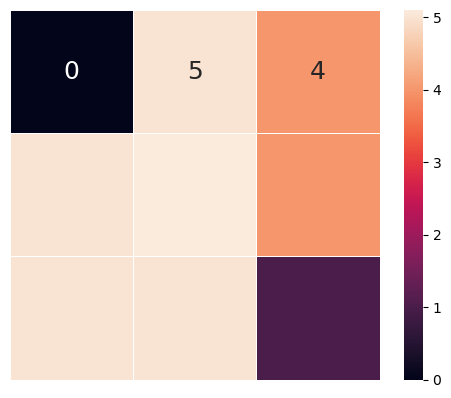

In [7]:
img_filtered = uf.highpass_filter(3.2)
sns.heatmap(img_filtered, annot=True, linewidths=0.5, square=True, yticklabels=False, xticklabels=False, annot_kws={"fontsize":18})

In [8]:
uf.persistence

array([[ 0., inf,  0.],
       [ 3.,  4.,  2.],
       [ 2.,  5.,  6.],
       [ 1.,  5.,  8.]])

## PH1: 1-dimensional

In [9]:
uf = ta.TopologicalFilterImage(img, dual=True)
uf.highpass_filter(2)

array([[0., 5., 3.],
       [5., 5., 4.],
       [2., 5., 1.]])

In [10]:
uf.persistence

array([[-inf,  inf,  0. ],
       [-5.1, -5. , 12. ]])

## Example with a real image

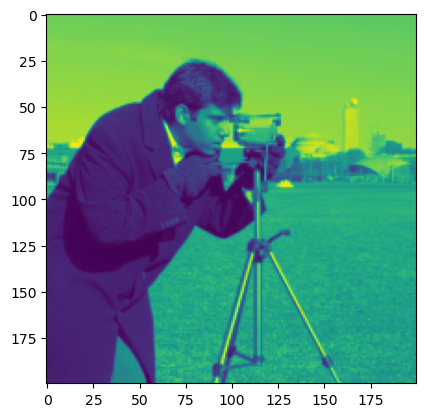

In [6]:
from skimage.transform import rescale, resize, downscale_local_mean
import skimage
from tqdm.auto import tqdm
import cripser, persim
plt.rcParams['text.usetex'] = False

n,m = 200,200
img = resize(skimage.data.camera(),(n,m))
plt.imshow(img)

  0%|          | 0/4 [00:00<?, ?it/s]

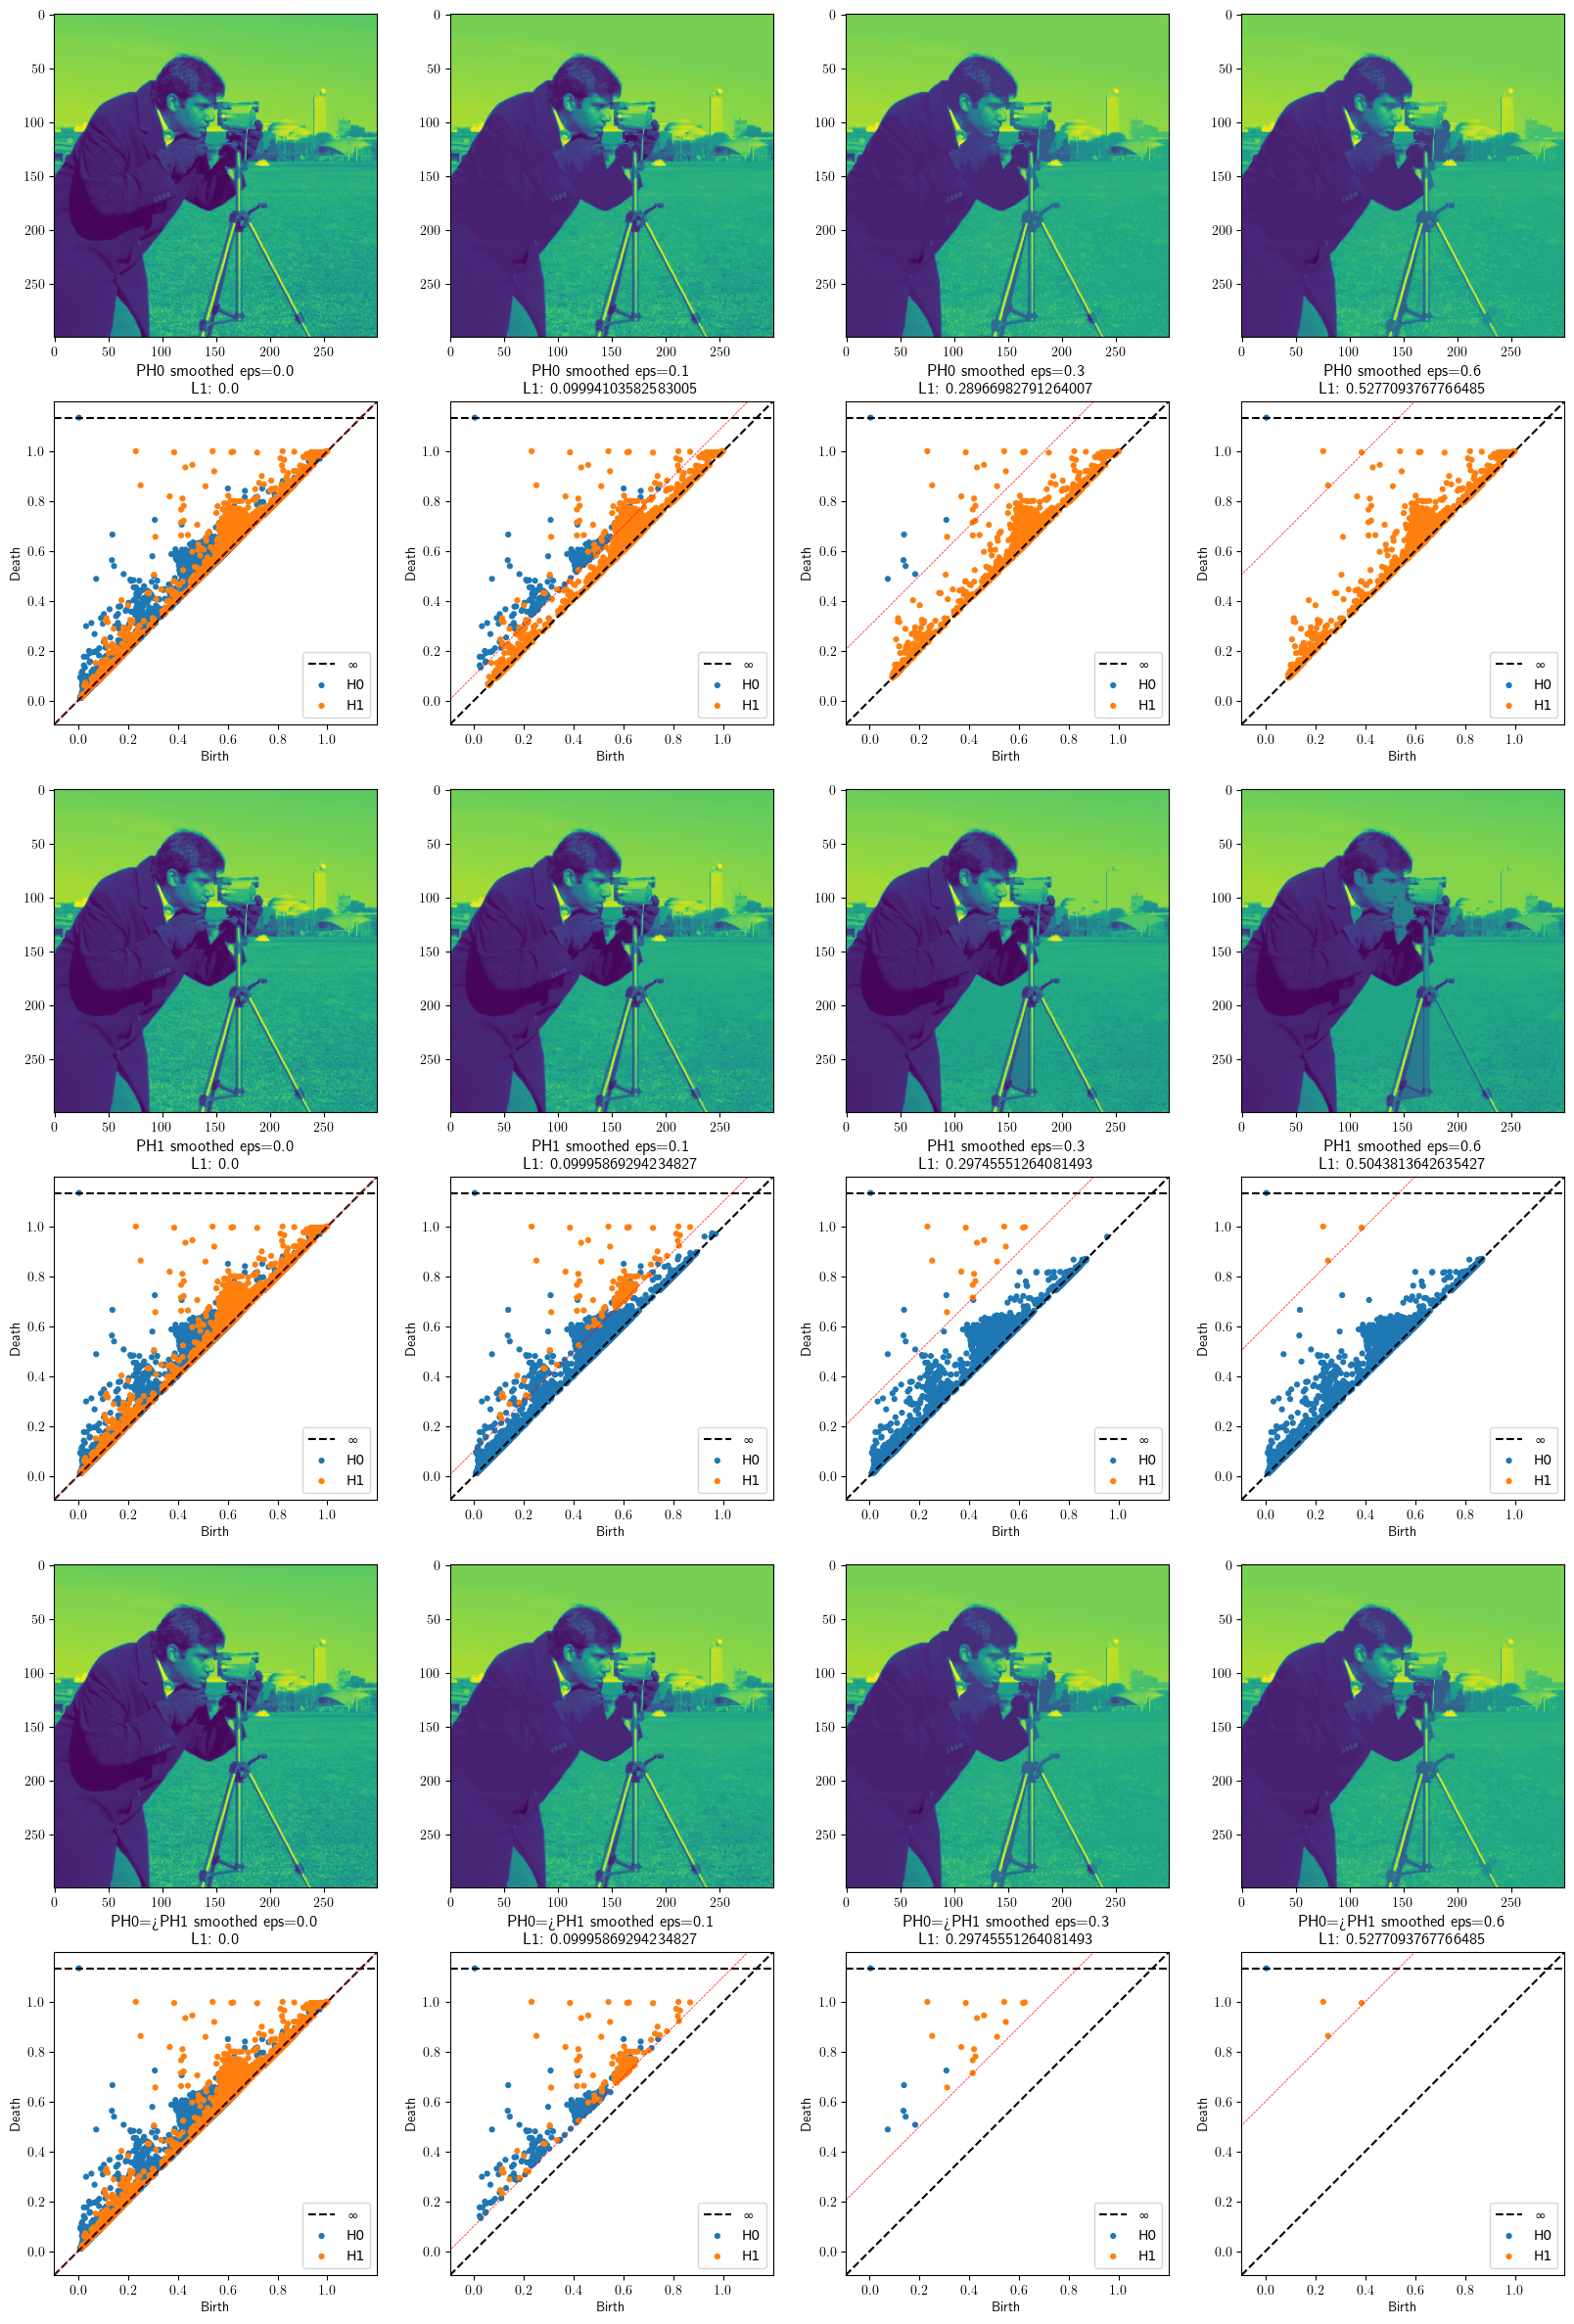

In [14]:
# filtering with different thresholds

thresholds=[0.0,0.1,0.3,0.6] # filtering thresholds
PD_original = cripser.computePH(img)
PD_original = [PD_original[PD_original[:,0]==i,1:3] for i in range(2)]

fig, axs = plt.subplots(6,len(thresholds),figsize=(20,30))
smoothed={}
smoothed1={}
smoothed2={}
a=ta.TopologicalFilterImage(img)
b=ta.TopologicalFilterImage(img, dual=True)
for i,s in enumerate(tqdm(thresholds)):
  PD_cutoff = [PD_original[i][PD_original[i][:,1]-PD_original[i][:,0]>=s] for i in range(2)]

  # PH0 smoothing
  smoothed[s] =a.highpass_filter(epsilon=s)
  axs[0,i].imshow(smoothed[s])
  PD_smoothed = cripser.computePH(smoothed[s])
  PD_smoothed = [PD_smoothed[PD_smoothed[:,0]==i,1:3] for i in range(2)]
  PD_smoothed_cutoff = [PD_smoothed[i][PD_smoothed[i][:,1]-PD_smoothed[i][:,0]>=s] for i in range(2)]
  persim.plot_diagrams(PD_smoothed,labels=["H0","H1"],ax=axs[1,i])
  axs[1,i].plot([-5,5], [-5+s,5+s], '--', linewidth=0.5, c="r")
  axs[1,i].set_title(f'PH0 smoothed eps={s} \n L1: {np.max(np.abs(smoothed[s]-img))}')# \n distance PH0: {persim.bottleneck(PD_smoothed[0],PD_cutoff[0])}\n PH1: {persim.bottleneck(PD_smoothed_cutoff[1],PD_cutoff[1])}')

  # PH1 smoothing
  smoothed1[s] =b.highpass_filter(epsilon=s)
  axs[2,i].imshow(smoothed1[s])
  PD_smoothed = cripser.computePH(smoothed1[s])
  PD_smoothed = [PD_smoothed[PD_smoothed[:,0]==i,1:3] for i in range(2)]
  PD_smoothed_cutoff = [PD_smoothed[i][PD_smoothed[i][:,1]-PD_smoothed[i][:,0]>=s] for i in range(2)]
  persim.plot_diagrams(PD_smoothed,labels=["H0","H1"],ax=axs[3,i])
  axs[3,i].plot([-5,5], [-5+s,5+s], '--', linewidth=0.5, c="r")
  axs[3,i].set_title(f'PH1 smoothed eps={s} \n L1: {np.max(np.abs(smoothed1[s]-img))}')# \n distance PH0: {persim.bottleneck(PD_smoothed[0],PD_cutoff[0])}\n PH1: {persim.bottleneck(PD_smoothed_cutoff[1],PD_cutoff[1])}')

  # PH0 => PH1 smoothing
  c=ta.TopologicalFilterImage(smoothed[s],dual=True)
  smoothed2[s] = c.highpass_filter(epsilon=s)
  axs[4,i].imshow(smoothed[s])
  PD_smoothed = cripser.computePH(smoothed2[s])
  PD_smoothed = [PD_smoothed[PD_smoothed[:,0]==i,1:3] for i in range(2)]
  persim.plot_diagrams(PD_smoothed,labels=["H0","H1"],ax=axs[5,i])
  axs[5,i].set_title(f'PH0=>PH1 smoothed eps={s} \n L1: {np.max(np.abs(smoothed2[s]-img))}')# \n distance PH0: {persim.bottleneck(PD_smoothed[0],PD_cutoff[0])} \n PH1: {persim.bottleneck(PD_smoothed[1],PD_cutoff[1])}')
  axs[5,i].plot([-5,5], [-5+s,5+s], '--', linewidth=0.5, c="r")


In [7]:
# setting keep_basin=True is slower for the first filtering but faster for later filtering
n,m = 300,300
img = resize(skimage.data.camera(),(n,m))
dual = False
thresholds=[0.0,0.1,0.3,0.6] # filtering thresholds

%time tf = ta.TopologicalFilterImage(img, dual=dual)
%time tf2 = ta.TopologicalFilterImage(img, dual=dual)
for i,s in enumerate(thresholds):
    print("\nepsilon",s)
    print("Compute persistence everytime")
    %time u = tf.highpass_filter(s, keep_basin=False)
    print("Re-use persistence")
    %time v = tf2.highpass_filter(s, keep_basin=True)
    #print(np.allclose(u,v))

CPU times: user 732 ms, sys: 55.8 ms, total: 788 ms
Wall time: 787 ms
CPU times: user 740 ms, sys: 32 ms, total: 772 ms
Wall time: 772 ms

epsilon 0.0
Compute persistence everytime
CPU times: user 3.52 s, sys: 443 ms, total: 3.96 s
Wall time: 3.16 s
Re-use persistence
CPU times: user 8.41 s, sys: 39.4 ms, total: 8.45 s
Wall time: 8.39 s

epsilon 0.1
Compute persistence everytime
CPU times: user 1.16 s, sys: 8.16 ms, total: 1.17 s
Wall time: 1.15 s
Re-use persistence
CPU times: user 438 ms, sys: 3.89 ms, total: 442 ms
Wall time: 442 ms

epsilon 0.3
Compute persistence everytime
CPU times: user 1.18 s, sys: 4.13 ms, total: 1.18 s
Wall time: 1.17 s
Re-use persistence
CPU times: user 41.4 ms, sys: 48 µs, total: 41.4 ms
Wall time: 41.3 ms

epsilon 0.6
Compute persistence everytime
CPU times: user 1.23 s, sys: 1.23 ms, total: 1.23 s
Wall time: 1.19 s
Re-use persistence
CPU times: user 43.3 ms, sys: 0 ns, total: 43.3 ms
Wall time: 43 ms


## Toy example with a planar graph

In [4]:
G=ta.TopologicalFilterGraph()
f={0:2, 1:1.5, 2:1, 3:1, 4:1, 5:2, 6:4, 7:3}
G.from_faces_nonfaces(F=[(0,1,2,3)],nF=[(1,2,4,3,0),(2,4,3)],filtration=f)
print(G.compute())
print(G.compute(dual=True))


[[ 1. inf]]
[[-inf  -1.]]


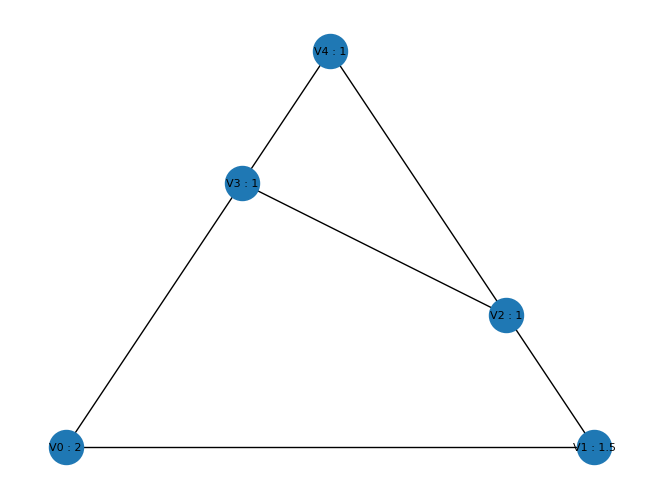

In [5]:
G.draw(with_labels=True,with_filtration=True)

## Image is a grid graph

In [10]:
from skimage.transform import rescale, resize, downscale_local_mean
import skimage

n,m = 150,100
img = resize(skimage.data.camera(),(n,m))

G=ta.TopologicalFilterGraph()
%time G.from_array(img)
%time u=G.compute(use_numba=False)
%time v=G.compute(use_numba=True)
np.allclose(u,v[:,:2])

CPU times: user 5.43 s, sys: 27.7 ms, total: 5.46 s
Wall time: 5.44 s
CPU times: user 217 ms, sys: 0 ns, total: 217 ms
Wall time: 217 ms
CPU times: user 1.08 s, sys: 12 ms, total: 1.09 s
Wall time: 1.09 s


True